# Gamma Mixed Effects Models
Created: 08/08/24 \
Updated: //2024 \


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08082024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

sns.set_theme(style='ticks') 
sns.set_context("poster")



In [8]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm


# saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# 671351
saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
saez_hex_cmap  = ListedColormap(saez_colors)
saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
#plot_palette = saez_linear_cmap.resampled(lutsize=30)
expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


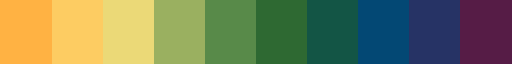

In [9]:
saez_full_cmap

# Load Regression DF

In [10]:
band = 'gamma'

In [11]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [12]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [13]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [14]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=20].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg',
 'temporal pole',
 'mcc',
 'motor',
 'phg',
 'parietal',
 'vmpfc']

In [15]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

244136

In [16]:
np.max(reg_df.band_pow)

3.83982303452732

In [17]:
np.min(reg_df.band_pow)

-0.9263426271969608

# POW ~ Outcome Vars Regressions

In [18]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [19]:
final_vars   = ['decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    band_pow   
No. Observations:     244112     Method:                ML         
No. Groups:           1776       Scale:                 0.0229     
Min. group size:      65         Log-Likelihood:        110950.0227
Max. group size:      148        Converged:             Yes        
Mean group size:      137.5                                        
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               -0.032    0.002 -15.469 0.000 -0.036 -0.028
decisionCPE              0.007    0.001   9.402 0.000  0.005  0.008
Group Var                0.008    0.002                            
Group x decisionCPE Cov  0.000    0.000                            
decisionCPE Var          0.000    0.000                        

-221825.6131141917

In [20]:
final_vars   = ['RPE','decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    band_pow   
No. Observations:     244112     Method:                ML         
No. Groups:           1776       Scale:                 0.0228     
Min. group size:      65         Log-Likelihood:        111058.4656
Max. group size:      148        Converged:             Yes        
Mean group size:      137.5                                        
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               -0.032    0.002 -15.469 0.000 -0.036 -0.028
RPE                      0.002    0.001   1.786 0.074 -0.000  0.004
decisionCPE              0.005    0.001   5.995 0.000  0.004  0.007
Group Var                0.008    0.002                            
Group x RPE Cov         -0.000    0.001                        

-221992.87738089144

In [21]:
final_vars   = ['TrialEV','RPE','decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     band_pow   
No. Observations:     244112      Method:                 ML         
No. Groups:           1776        Scale:                  0.0227     
Min. group size:      65          Log-Likelihood:         111179.1156
Max. group size:      148         Converged:              Yes        
Mean group size:      137.5                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -0.032    0.002 -15.472 0.000 -0.036 -0.028
TrialEV                    0.003    0.001   3.950 0.000  0.001  0.004
RPE                        0.001    0.001   1.441 0.150 -0.001  0.004
decisionCPE                0.006    0.001   6.258 0.000  0.004  0.008
Group Var                  0.008    

-222172.1504862372

In [22]:
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           244112           Method:                      ML         
No. Groups:                 1776             Scale:                       0.0222     
Min. group size:            65               Log-Likelihood:              112892.3020
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.5                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.033    0.002 -15.231 0.000 -0.037 -0.028
C(GambleChoice)[T.safe]                    0.002    0.001   1.975 0.048  0.000

-225598.52330754307

In [23]:
final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            band_pow   
No. Observations:            244112             Method:                        ML         
No. Groups:                  1776               Scale:                         0.0222     
Min. group size:             65                 Log-Likelihood:                112611.8353
Max. group size:             148                Converged:                     Yes        
Mean group size:             137.5                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.029    0.002 -13.337 0.000 -0.033 -0.025
C(TrialType)[T.loss]      

-224876.31988056592

In [24]:
final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           244112           Method:                      ML         
No. Groups:                 1776             Scale:                       0.0221     
Min. group size:            65               Log-Likelihood:              112961.7918
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.5                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.033    0.002 -15.538 0.000 -0.038 -0.029
C(GambleChoice)[T.safe]                    0.004    0.001   3.490 0.000  0.002

-225663.07065107286

In [25]:
final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           244112           Method:                      ML         
No. Groups:                 1776             Scale:                       0.0226     
Min. group size:            65               Log-Likelihood:              111506.7948
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.5                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.034    0.002 -15.588 0.000 -0.038 -0.029
C(GambleChoice)[T.safe]                    0.004    0.001   3.793 0.000  0.002

-222827.508890549

In [26]:
final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      band_pow   
No. Observations:       244112       Method:                  ML         
No. Groups:             1776         Scale:                   0.0223     
Min. group size:        65           Log-Likelihood:          112478.8841
Max. group size:        148          Converged:               Yes        
Mean group size:        137.5                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -0.032    0.002 -15.472 0.000 -0.036 -0.028
TrialEV                        0.003    0.001   4.317 0.000  0.002  0.005
TotalProfit                   -0.001    0.001  -1.167 0.243 -0.004  0.001
decisionCPE                    0.007    0.001   9.263 0.

-224771.6873856092

In [27]:
final_vars   = ['C(GambleChoice)', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           244112           Method:                      ML         
No. Groups:                 1776             Scale:                       0.0226     
Min. group size:            65               Log-Likelihood:              111453.9818
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.5                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.033    0.002 -15.310 0.000 -0.037 -0.029
C(GambleChoice)[T.safe]                    0.002    0.001   2.357 0.018  0.000

-222783.9098229997

In [28]:
final_vars   = ['TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      band_pow   
No. Observations:       244112       Method:                  ML         
No. Groups:             1776         Scale:                   0.0224     
Min. group size:        65           Log-Likelihood:          112360.8930
Max. group size:        148          Converged:               Yes        
Mean group size:        137.5                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -0.032    0.002 -15.467 0.000 -0.036 -0.028
TotalProfit                   -0.001    0.001  -1.034 0.301 -0.004  0.001
decisionCPE                    0.007    0.001   9.299 0.000  0.005  0.008
Group Var                      0.008    0.002           

-224597.73219346508

In [29]:
final_vars   = ['TrialEV', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     band_pow   
No. Observations:     244112      Method:                 ML         
No. Groups:           1776        Scale:                  0.0228     
Min. group size:      65          Log-Likelihood:         111042.7843
Max. group size:      148         Converged:              Yes        
Mean group size:      137.5                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -0.032    0.002 -15.476 0.000 -0.036 -0.028
TrialEV                    0.003    0.001   4.004 0.000  0.002  0.004
decisionCPE                0.007    0.001   9.386 0.000  0.005  0.008
Group Var                  0.008    0.002                            
Group x TrialEV Cov       -0.000    

-221961.5147740177

In [30]:
final_vars   = ['C(TrialType)','decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            band_pow   
No. Observations:            244112             Method:                        ML         
No. Groups:                  1776               Scale:                         0.0228     
Min. group size:             65                 Log-Likelihood:                111052.3759
Max. group size:             148                Converged:                     Yes        
Mean group size:             137.5                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.029    0.002 -13.566 0.000 -0.033 -0.025
C(TrialType)[T.loss]      

-221918.67102764436

In [31]:
final_vars   = ['C(TrialType)','TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            band_pow   
No. Observations:            244112             Method:                        ML         
No. Groups:                  1776               Scale:                         0.0223     
Min. group size:             65                 Log-Likelihood:                112510.1846
Max. group size:             148                Converged:                     Yes        
Mean group size:             137.5                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.029    0.002 -13.465 0.000 -0.033 -0.025
C(TrialType)[T.loss]      

-224759.85620015473

In [32]:
final_vars   = ['C(TrialType)','TrialEV',  'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            band_pow   
No. Observations:            244112             Method:                        ML         
No. Groups:                  1776               Scale:                         0.0227     
Min. group size:             65                 Log-Likelihood:                111143.6040
Max. group size:             148                Converged:                     Yes        
Mean group size:             137.5                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.029    0.002 -13.406 0.000 -0.033 -0.025
C(TrialType)[T.loss]      

-222026.69495317465


## ROI REGRESSIONS


In [ ]:
# test_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy','motor']


In [61]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
# final_vars   = ['C(GambleChoice)','TotalProfit','decisionCPE']
final_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE']

In [62]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)



In [63]:
roi_fit

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TrialEV,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TrialEV,TotalProfit,decisionCPE
0,MS025_lcmip1-lcmip2,MS025,thalamus,10,-0.041922,-0.004963,0.006384,0.003467,-0.001334,-0.050603,-0.006667,0.012756,0.003826,0.007244
1,MS025_lcmip2-lcmip3,MS025,thalamus,10,-0.055986,0.008029,0.002798,-0.005047,-0.012606,-0.064667,0.006324,0.009169,-0.004689,-0.004028
2,MS025_lcmip3-lcmip4,MS025,thalamus,10,-0.156567,0.000332,0.016193,-0.010816,-0.014807,-0.165248,-0.001372,0.022565,-0.010457,-0.006229
3,MS025_lcmip4-lcmip5,MS025,thalamus,10,-0.068655,0.002167,0.009130,-0.000231,-0.009384,-0.077336,0.000463,0.015501,0.000128,-0.000806
4,MS025_lcmip5-lcmip6,MS025,thalamus,10,-0.022672,-0.014433,-0.004102,-0.005920,0.010347,-0.031353,-0.016138,0.002270,-0.005562,0.018925
5,MS025_rcmip1-rcmip2,MS025,thalamus,10,0.014058,0.001088,0.001301,-0.003475,0.002781,0.005377,-0.000617,0.007673,-0.003116,0.011359
6,MS025_rcmip2-rcmip3,MS025,thalamus,10,0.000316,0.003808,0.002802,-0.004582,-0.000799,-0.008365,0.002103,0.009173,-0.004223,0.007779
7,MS025_rcmip3-rcmip4,MS025,thalamus,10,0.014386,-0.002828,-0.002669,-0.000395,0.003989,0.005706,-0.004533,0.003703,-0.000037,0.012567
8,MS025_rcmip4-rcmip5,MS025,thalamus,10,0.017604,-0.004096,-0.003901,-0.002547,0.006017,0.008923,-0.005801,0.002471,-0.002188,0.014595
9,MS025_rcmip5-rcmip6,MS025,thalamus,10,0.018533,0.000242,-0.004049,0.001687,0.000748,0.009852,-0.001463,0.002323,0.002045,0.009326


In [64]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TrialEV,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TrialEV,TotalProfit,decisionCPE
0,DA023_lac1-lac2,DA023,acc,14,-0.002726,0.009389,-0.004393,-0.013368,-0.001285,-0.010328,0.000528,-0.000100,-0.019090,0.009592
1,DA023_lac2-lac3,DA023,acc,14,0.004485,0.003838,0.000036,-0.007406,-0.001002,-0.003116,-0.005024,0.004329,-0.013128,0.009875
2,DA023_lac3-lac4,DA023,acc,14,0.004275,0.005640,-0.010043,0.022508,-0.012744,-0.003327,-0.003222,-0.005750,0.016786,-0.001867
3,MS002_lacas1-lacas2,MS002,acc,14,0.018989,-0.020967,0.023306,-0.026256,0.013551,0.011387,-0.029829,0.027600,-0.031978,0.024428
4,MS002_lacas2-lacas3,MS002,acc,14,0.010909,-0.005187,0.011731,0.001862,0.009921,0.003307,-0.014049,0.016024,-0.003860,0.020798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,MS050_lcmang3-lcmang4,MS050,thalamus,9,-0.000124,-0.005131,-0.003611,-0.024015,0.012411,-0.008805,-0.006836,0.002761,-0.023656,0.020989
1772,MS050_lcmang4-lcmang5,MS050,thalamus,9,-0.028154,-0.002956,-0.000938,-0.022478,0.006560,-0.036835,-0.004661,0.005434,-0.022119,0.015138
1773,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,-0.003792,0.012292,0.012838,-0.020690,-0.000039,-0.012473,0.010588,0.019210,-0.020331,0.008539
1774,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.008141,-0.002234,-0.001519,0.004890,0.000918,-0.000540,-0.003939,0.004853,0.005249,0.009496


In [65]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [66]:
# fe_params_results

In [67]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [68]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [69]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [70]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TrialEV,TotalProfit,decisionCPE,roi,roi_cpe_pval
0,-0.007602,-0.008862,0.004293,-0.005722,0.010877,acc,0.0000
1,-0.022587,0.001481,0.007129,-0.010946,0.001704,dmpfc,0.3845
2,-0.061151,0.008435,0.003369,0.004929,0.012775,amy,0.0000
3,-0.041715,-0.001656,0.008527,-0.002837,-0.000010,sts,0.9967
4,0.010935,0.001540,0.003932,0.012062,0.010648,ains,0.0084
5,-0.007979,0.009476,-0.000279,-0.004208,0.008089,vlpfc,0.0398
6,-0.082264,0.007581,0.006616,0.005753,0.004941,hpc,0.0825
7,-0.054147,0.007831,0.009189,0.000605,0.003140,mtg,0.4469
8,-0.028459,0.016876,0.003401,-0.004953,0.015306,ofc,0.0000
9,-0.053926,0.003631,-0.001342,0.018895,0.004329,pins,0.2565


In [55]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TotalProfit,decisionCPE,roi,roi_cpe_pval
0,-0.006639,-0.010650,-0.005460,0.010991,acc,1.000000e-10
1,-0.021553,-0.000675,-0.010544,0.002224,dmpfc,2.549589e-01
2,-0.060471,0.007477,0.005206,0.012131,amy,1.331280e-05
3,-0.040161,-0.004734,-0.002706,0.000258,sts,9.162264e-01
4,0.011500,0.000393,0.012253,0.010158,ains,1.275728e-02
5,-0.008139,0.010334,-0.003690,0.007988,vlpfc,4.393738e-02
6,-0.081145,0.005385,0.006147,0.004963,hpc,7.312061e-02
7,-0.052687,0.004734,0.000575,0.003428,mtg,4.188887e-01
8,-0.027739,0.015319,-0.005054,0.015146,ofc,0.000000e+00
9,-0.054050,0.003830,0.019004,0.004468,pins,2.386900e-01


In [57]:
ofc_fit = fit_mixed_model(reg_df[reg_df.roi=='ofc'],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
ofc_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          band_pow  
No. Observations:           27836            Method:                      ML        
No. Groups:                 202              Scale:                       0.0242    
Min. group size:            65               Log-Likelihood:              11668.0208
Max. group size:            148              Converged:                   Yes       
Mean group size:            137.8                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 -0.028    0.008 -3.536 0.000 -0.043 -0.012
C(GambleChoice)[T.safe]                    0.015    0.003  4.499 0.000  0.009  0.022
TotalProfit                               -0.005    0.003 -1.955 0.051 -0.010  0.000
decisionCPE                                0.015    0.002  6.731 0.000  0.011  0.020
Group Var                                  0.012    0.008                           
Group x C(GambleChoice)[T.safe] Cov        0.000    0.002                           
C(GambleChoice)[T.safe] Var                0.002    0.002                           
Group x TotalProfit Cov                    0.000    0.002                           
C(GambleChoice)[T.safe] x TotalProfit Cov  0.000    0.001                           
TotalProfit Var                            0.001    0.001                           
Group x decisionCPE Cov                   -0.000    0.002                           
C(GambleChoice)[T.safe] x decisionCPE Cov  0.000    0.001                           
TotalProfit x decisionCPE Cov              0.000    0.001                           
decisionCPE Var                            0.000    0.001                           
====================================================================================

"""

In [59]:
ofc_fit.pvalues

Intercept                                    4.066084e-04
C(GambleChoice)[T.safe]                      6.840260e-06
TotalProfit                                  5.062433e-02
decisionCPE                                  1.680687e-11
Group Var                                    2.338770e-22
Group x C(GambleChoice)[T.safe] Cov          9.680822e-01
C(GambleChoice)[T.safe] Var                  6.060462e-11
Group x TotalProfit Cov                      5.882490e-01
C(GambleChoice)[T.safe] x TotalProfit Cov    7.511020e-01
TotalProfit Var                              3.397954e-06
Group x decisionCPE Cov                      2.993190e-01
C(GambleChoice)[T.safe] x decisionCPE Cov    1.823343e-01
TotalProfit x decisionCPE Cov                3.374314e-02
decisionCPE Var                              2.573911e-03
dtype: float64

In [58]:
acc_fit = fit_mixed_model(reg_df[reg_df.roi=='acc'],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
acc_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          band_pow  
No. Observations:           26558            Method:                      ML        
No. Groups:                 193              Scale:                       0.0139    
Min. group size:            65               Log-Likelihood:              18821.7025
Max. group size:            148              Converged:                   Yes       
Mean group size:            137.6                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 -0.007    0.002 -3.761 0.000 -0.010 -0.003
C(GambleChoice)[T.safe]                   -0.011    0.002 -4.812 0.000 -0.015 -0.006
TotalProfit                               -0.005    0.002 -2.185 0.029 -0.010 -0.001
decisionCPE                                0.011    0.002  6.485 0.000  0.008  0.014
Group Var                                  0.000    0.001                           
Group x C(GambleChoice)[T.safe] Cov       -0.000    0.001                           
C(GambleChoice)[T.safe] Var                0.001    0.001                           
Group x TotalProfit Cov                    0.000    0.001                           
C(GambleChoice)[T.safe] x TotalProfit Cov  0.000    0.001                           
TotalProfit Var                            0.001    0.001                           
Group x decisionCPE Cov                    0.000    0.000                           
C(GambleChoice)[T.safe] x decisionCPE Cov -0.000    0.000                           
TotalProfit x decisionCPE Cov             -0.000    0.001                           
decisionCPE Var                            0.000    0.000                           
====================================================================================

"""

In [60]:
acc_fit.pvalues

Intercept                                    1.693959e-04
C(GambleChoice)[T.safe]                      1.497019e-06
TotalProfit                                  2.889127e-02
decisionCPE                                  8.853343e-11
Group Var                                    4.233588e-09
Group x C(GambleChoice)[T.safe] Cov          1.025548e-05
C(GambleChoice)[T.safe] Var                  9.719440e-08
Group x TotalProfit Cov                      2.676891e-01
C(GambleChoice)[T.safe] x TotalProfit Cov    3.909127e-03
TotalProfit Var                              1.715671e-10
Group x decisionCPE Cov                      2.888112e-01
C(GambleChoice)[T.safe] x decisionCPE Cov    1.425919e-01
TotalProfit x decisionCPE Cov                1.284158e-01
decisionCPE Var                              9.346204e-03
dtype: float64

In [37]:

# sns.set_context("talk",rc={'axes.linewidth': 1.5})

# for roi in roi_plot_data.roi.unique().tolist()[:-1]:
#     roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
#     fig,ax = plt.subplots(1,1,figsize=(5,3.5),dpi=300)

#     sns.regplot(data=roi_temp_data,x='bdi',y='elec_bCPE',scatter=False,ci=95,
#                 fit_reg=True,color = '#00467e') #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
# #     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
#     plt.xlabel('BDI-II')
# #     plt.xlim([0,40])
    
#     plt.tick_params(length=0) 
# #     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
# #              color='#00467e',fontsize=16)
# #     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
# #             verticalalignment='top', horizontalalignment='right',
# #             color='k',fontsize=16)

#     plt.title(f'{roi}',fontsize=20)
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

In [ ]:
sig_roi_fit_results

In [ ]:
roi_fit_results

In [ ]:
bonferr_alpha = 0.05/len(test_rois)

In [ ]:
bonferr_alpha

In [ ]:
fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha]

In [ ]:
sig_roi_fit_results = roi_fit_results[roi_fit_results.decisionCPE <= 0.05]

In [ ]:
sig_roi_fit_results.roi.value_counts()

In [ ]:
sig_roi_fit_results

In [ ]:
plot_roi_model_results(sig_data,'roi','Z_Score_decisionCPE',bar_order=bar_order,color='#135546',figsize=(10,4))

In [ ]:
final_fit.pvalues['decisionCPE']

In [ ]:
# final_fit.t_test_pairwise('C(TrialType)',
#                           factor_labels=[ 'TrialEV', 'TotalProfit', 'decisionCPE'])
# final_fit.model.data.design_info.term_names.index(term_name)

In [ ]:
mixed_effects_ftest_ttest(final_fit)

In [ ]:
fe_param_names = list(final_fit.fe_params.index[1:])
fe_param_names

In [ ]:
plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':final_fit.random_effects[elec_id][param] for param in list(
            final_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in final_fit.random_effects.keys()]).reset_index(drop=True)

plot_data['roi'] = [reg_df.roi[reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]

In [ ]:
plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = final_fit.params['Intercept']
fe_cpe_beta    = final_fit.params['decisionCPE']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
plot_data['elec_b0']   = np.add(plot_data.raw_Group,fe_intercept)
plot_data['elec_bCPE'] = np.add(plot_data.raw_decisionCPE,fe_cpe_beta)
plot_data = plot_data[~plot_data.roi.isnull()]

In [ ]:
plot_data

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(plot_data.raw_decisionCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
pairwise_ains_vals = plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats = {f'ains={roi}':ttest_ind(pairwise_ains_vals,plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 ) for roi in plot_data.roi.unique().tolist()}
pairwise_roi_stats


In [ ]:
pairwise_ains_vals = plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats_greater = {f'ains={roi}':ttest_ind(pairwise_ains_vals,plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 alternative='greater') for roi in plot_data.roi.unique().tolist()}
pairwise_roi_stats_greater

In [ ]:
pairwise_ains_vals = plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats_less = {f'ains={roi}':ttest_ind(pairwise_ains_vals,plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 alternative='less') for roi in plot_data.roi.unique().tolist()}
pairwise_roi_stats_less

In [ ]:
bonferr_alpha = 0.05/(len(plot_data.roi.unique().tolist()))
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())

sig_raw = [(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha]

sig_raw_rois = list(zip(*sig_raw))[0]

In [ ]:
sig_raw_rois

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
list(zip(*sig_bcpe))[0]

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_greater[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,pairwise_roi_stats_greater[roi].pvalue) for roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
sig_bcpe_rois 

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_less[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_less.keys()
                                                   if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
# sig_bcpe = [(roi,pairwise_roi_stats_less[roi].pvalue) for roi in pairwise_roi_stats_less.keys()
#                                                    if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha]

# sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats[roi].pvalue) for 
                                                   roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha])

sig_bcpe = [(roi,pairwise_roi_stats[roi].pvalue) for roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
sig_bcpe_rois

In [ ]:
len([(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])

In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
roi_plot_data = plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(10, 4),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#             y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#346a97',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#               y='raw_decisionCPE',
#               color='#78496b', 
              color = '#00467e',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 6)

ax.axhline(y=0,color='#00467e',linewidth=2)
plt.tick_params(length=0 )#,grid_linewidth=1)

plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
plt.ylabel(r'$beta_{{{zpow}}} \sim cpe$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [ ]:
roi_plot_data.roi.unique().tolist()

In [ ]:
bonferr_alpha

In [ ]:
rho_data = []
sig_rho = []

# bonferr_alpha = 0.05/len(roi_plot_data.roi.unique().tolist())
# bonferr_alpha = 0.05/9
bonferr_alpha = 0.01

# BDI CORRELATIONS
for roi in roi_plot_data.roi.unique().tolist()[:]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]
    rho,rho_p     = spearmanr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


In [ ]:
rho_data

In [ ]:
sig_rho

In [ ]:
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data['round_p']   = np.round(rho_data.rho_p,2)
rho_data['round_p'][rho_data.roi == 'acc'] = 0.01
rho_data['round_p'][rho_data.roi == 'ofc'] = 0.01
rho_data

In [ ]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(5,3.5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='elec_bCPE',scatter=False,ci=95,
                fit_reg=True,color = '#00467e') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(r'$beta_{{{zpow}}} \sim cpe$')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
             r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}',fontsize=20)
    plt.tight_layout()


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

# Band x BDI Interaction
- Rerun final mixed effects model on each ROI separately
- Correlate random effects slopes for each regressor with BDI

In [ ]:
rand_eff_var = 'unique_reref_ch'


In [ ]:
reg_df

In [ ]:
bdi_vars    = ['decisionCPE','bdi','decisionCPE:bdi']
outcome_var = 'band_pow'

bdi_fit = fit_mixed_model(reg_df,bdi_vars,outcome_var,rand_eff_var,reml=False)
print(bdi_fit.summary())
    

In [ ]:
fe_param_names = list(bdi_fit.fe_params.index[1:])
fe_param_names

In [ ]:
bdi_plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':bdi_fit.random_effects[elec_id][param] for param in list(
            bdi_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in bdi_fit.random_effects.keys()]).reset_index(drop=True)

bdi_plot_data['roi'] = [reg_df.roi[reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in bdi_plot_data.iterrows()]

bdi_plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in bdi_plot_data.subj_id]

In [ ]:
bdi_plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = bdi_fit.params['Intercept']
fe_cpe_beta    = bdi_fit.params['decisionCPE:bdi']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
bdi_plot_data['elec_b0']   = np.add(bdi_plot_data.raw_Group,fe_intercept)
bdi_plot_data['elec_bCPE'] = np.add(bdi_plot_data['raw_decisionCPE:bdi'],fe_cpe_beta)
bdi_plot_data = bdi_plot_data[~bdi_plot_data.roi.isnull()]

In [ ]:
bdi_plot_data

In [ ]:
# raw_bdi

raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_decisionCPE:bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
pairwise_ains_vals = bdi_plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats = {f'ains={roi}':ttest_ind(pairwise_ains_vals,bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 ) for roi in bdi_plot_data.roi.unique().tolist()}
pairwise_roi_stats


In [ ]:
pairwise_ains_vals = bdi_plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats_greater = {f'ains={roi}':ttest_ind(pairwise_ains_vals,bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 alternative='greater') for roi in bdi_plot_data.roi.unique().tolist()}
pairwise_roi_stats_greater

In [ ]:
pairwise_ains_vals = bdi_plot_data.elec_bCPE[bdi_plot_data.roi == 'ains'].unique()

pairwise_roi_stats_less = {f'ains={roi}':ttest_ind(pairwise_ains_vals,bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 alternative='less') for roi in bdi_plot_data.roi.unique().tolist()}
pairwise_roi_stats_less

In [ ]:
bonferr_alpha = 0.05/len(roi_order)
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())

sig_raw = [(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha]

sig_raw_rois = list(zip(*sig_raw))[0]

In [ ]:
sig_raw_rois

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
list(zip(*sig_bcpe))[0]

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_greater[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,pairwise_roi_stats_greater[roi].pvalue) for roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha]

# sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
# sig_bcpe_rois 

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_less[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_less.keys()
                                                   if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,pairwise_roi_stats_less[roi].pvalue) for roi in pairwise_roi_stats_less.keys()
                                                   if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats[roi].pvalue) for 
                                                   roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha])

sig_bcpe = [(roi,pairwise_roi_stats[roi].pvalue) for roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

In [ ]:
sig_bcpe_rois

In [ ]:
len([(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])

In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
roi_plot_data = bdi_plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
bdi_plot_data.roi.unique()

In [ ]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(10, 4),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/{band}_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = bdi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#             y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#173b6f',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = bdi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#               y='raw_decisionCPE',
#               color='#78496b', 
              color = '#173b6f',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 6)

ax.axhline(y=0,color='#173b6f',linewidth=2)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe:bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE:BDI_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [ ]:
bdi_plot_data.roi.unique().tolist()

In [ ]:
bonferr_alpha

In [ ]:
rho_data = []
sig_rho = []

# bonferr_alpha = 0.05/len(roi_plot_data.roi.unique().tolist())
# bonferr_alpha = 0.05/9
bonferr_alpha = 0.01

# BDI CORRELATIONS
for roi in roi_plot_data.roi.unique().tolist()[:]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]
    rho,rho_p     = spearmanr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


In [ ]:
rho_data

In [ ]:
sig_rho

In [ ]:
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data['round_p']   = np.round(rho_data.rho_p,3)
# rho_data['round_p'][rho_data.roi == 'acc'] = 0.01
# rho_data['round_p'][rho_data.roi == 'ofc'] = 0.01
rho_data

In [ ]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(5,3.5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,ci=95,
                fit_reg=True,color = '#173b6f') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#173b6f',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe:bdi$')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').raw_decisionCPE),3)-0.003,
             r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}',fontsize=20)
    plt.tight_layout()
    


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_{band}-cpe:bdi-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [ ]:
reg_df

In [ ]:
reg_df['Depressed'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in reg_df.bdi.tolist()]

In [ ]:
## X plot attempt 

sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5))
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=reg_df[reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':5})
sns.regplot(data=reg_df[reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':5})

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.tight_layout()
plt.ylabel(fr'${band}_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

In [ ]:
reg_df['Depressed'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in reg_df.bdi.tolist()]

In [ ]:
## X plot attempt 

sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5))
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=reg_df[reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=reg_df[reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#0b4e5f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.tight_layout()
plt.ylabel(fr'${band}_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

In [ ]:
for roi in reg_df.roi.unique().tolist():
    roi_reg_plot = reg_df[reg_df.roi== roi]
    fig,ax = plt.subplots(figsize=(8,5))

    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
               ci=95,color = '#824973',label='Low BDI')#,scatter_kws={'s':2})
    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
               ci=95,color='#0b4e5f',label='High BDI')#,scatter_kws={'s':2})

    plt.legend(fontsize=10)
    # borderaxespad=0,frameon=False,framealpha=0,
    sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                    fontsize='small',shadow=None,
                    columnspacing=2,ncol=2)


    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.ylabel(fr'${band}_{{{zpow}}}$')
    plt.xlabel(r'$cpe(z)$')
    plt.title(f'{roi}')
    sns.despine()
    plt.tick_params(length=0)
    
    

In [ ]:
for roi in reg_df.roi.unique().tolist():
    roi_reg_plot = reg_df[reg_df.roi== roi]
    fig,ax = plt.subplots(figsize=(8,5))

    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
               ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':5})
    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
               ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':5})

    plt.legend(fontsize=10)
    # borderaxespad=0,frameon=False,framealpha=0,
    sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                    fontsize='small',shadow=None,
                    columnspacing=2,ncol=2)


    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.ylabel(fr'${band}_{{{zpow}}}$')
    plt.xlabel(r'$cpe(z)$')
    plt.title(f'{roi}')
    sns.despine()
    plt.tick_params(length=0)
    
    

In [ ]:
# for roi in reg_df.roi.unique().tolist():
#     roi_reg_plot = reg_df[reg_df.roi== roi]
#     fig,ax = plt.subplots(figsize=(8,5),dpi=500)

#     sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
#                ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15)#,scatter_kws={'s':2})
#     sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
#                ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15)#,scatter_kws={'s':2})

#     plt.legend(fontsize=10)
#     # borderaxespad=0,frameon=False,framealpha=0,
#     sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
#                     fontsize='small',shadow=None,
#                     columnspacing=2,ncol=2)


#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

#     plt.ylabel(r'$beta_{{{zpow}}}$')
#     plt.xlabel(r'$cpe(z)$')
#     plt.title(f'{roi}')
#     sns.despine()
#     plt.tick_params(length=0)
    
    

In [ ]:
fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=reg_df[reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':2})
sns.regplot(data=reg_df[reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':2})

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(fr'${band}_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)



In [ ]:
palette=dict(Low="#3f2755", High="#054a6f")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


In [ ]:
from scipy import stats
# slope, intercept, r_value, p_value, std_err = stats.linregress(df.x,df.y)

In [ ]:
reg_df['Depression'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in reg_df.bdi.tolist()]

In [ ]:
# edgecolor=None,markerfirst=True,title=None,#title_fontsize='x-small',
#                 markerscale=0.2,labelcolor=None

In [ ]:
roi_order = ['dlpfc','vlpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
lmplot

In [ ]:
reg_df

In [ ]:
lmplot = reg_df.copy()
lmplot = lmplot.groupby('unique_reref_ch').agg('mean').reset_index()

# beta_lmplot['Depressed'] = ['Low BDI' if bdi =< 20 else 'High BDI' for bdi in beta_lmplot.bdi]


# beta_lmplot['raw_rt_coeff']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
#     'raw_decisionCPE:band_pow'].values[0] for elec in beta_lmplot.unique_reref_ch]

# beta_lmplot['elec_bCPE']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
#     'elec_bCPE'].values[0] for elec in beta_lmplot.unique_reref_ch]

lmplot['roi']  = [reg_df[reg_df.unique_reref_ch == elec][
    'roi'].values[0] for elec in reg_df.unique_reref_ch]

lmplot = lmplot[lmplot.roi.isin(roi_order)]

lmplot

In [ ]:
roi_not_ains = ['notIns' if roi != 'ains' else 'ains' for roi in reg_df.roi.tolist()]
roi_not_ains

In [ ]:
reg_df['roi_not_ains'] = roi_not_ains

In [ ]:
final_vars = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']


In [ ]:

final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
    

In [ ]:
final_fit.pvalues['decisionCPE']

In [ ]:
mixed_effects_ftest_ttest(final_fit)

In [ ]:
fe_param_names = list(final_fit.fe_params.index[1:])
fe_param_names

In [ ]:
plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':final_fit.random_effects[elec_id][param] for param in list(
            final_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in final_fit.random_effects.keys()]).reset_index(drop=True)

plot_data['roi'] = [reg_df.roi[reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]

In [ ]:
plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = final_fit.params['Intercept']
fe_cpe_beta    = final_fit.params['decisionCPE']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
plot_data['elec_b0']   = np.add(plot_data.raw_Group,fe_intercept)
plot_data['elec_bCPE'] = np.add(plot_data.raw_decisionCPE,fe_cpe_beta)
plot_data = plot_data[~plot_data.roi.isnull()]

In [ ]:
plot_data

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(plot_data.raw_decisionCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/(len(plot_data.roi.unique().tolist()))
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']

In [ ]:
roi_plot_data = plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
# roi_plot_data

In [ ]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/{band}_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
            y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#346a97',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
              y='raw_decisionCPE',
#               color='#78496b', 
              color = '#00467e',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#00467e',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
plt.ylabel(fr'${band}_{{{zpow}}}$'+ ' cpe encoding')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [ ]:
rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.raw_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
    if rho_p < bonferr_alpha: 
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


In [ ]:
sig_rho

In [ ]:
rho_data['plot_p'] = [0.001 if roi.rho_p < 0.001 else np.round(roi.rho_p,4) for ix,roi in rho_data.iterrows()]

In [ ]:
new_plot_ps = []
for p in rho_data['plot_p']:
    new_p = 0
    
    for ix,val in enumerate(str(p)):
        if val == '0':
            continue
        elif val == '.':
            continue
        else: 
#             print(ix,val)
            new_p = str(p)[:ix+1]
            break
            
            

    new_plot_ps.append(float(new_p))
#         print(val)

In [ ]:
rho_data['round_p']   = new_plot_ps
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data

In [ ]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig = plt.figure(figsize=(7,5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,ci=95,
                fit_reg=True,color = '#00467e') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
    
    plt.tick_params(length=0) 
    plt.ylabel(band+r'$_{{{zpow}}}$'+' cpe encoding')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').raw_decisionCPE),3)-0.003,
             r'$rho$ = '+f'{rho} '+'\n '+r'$p < $'+f'{rho_p}',
             color='#00467e',fontsize=16)

    plt.title(f'{roi}',fontsize=24)


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_{band}-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

# BDI Interaction
- Rerun final mixed effects model on each ROI separately
- Correlate random effects slopes for each regressor with BDI

In [ ]:
rand_eff_var = 'unique_reref_ch'


In [ ]:
reg_df

In [ ]:
bdi_vars    = ['decisionCPE','bdi','decisionCPE:bdi']
outcome_var = 'band_pow'

bdi_fit = fit_mixed_model(reg_df,bdi_vars,outcome_var,rand_eff_var,reml=False)
print(bdi_fit.summary())
    

In [ ]:
fe_param_names = list(bdi_fit.fe_params.index[1:])
fe_param_names

In [ ]:
bdi_plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':bdi_fit.random_effects[elec_id][param] for param in list(
            bdi_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in bdi_fit.random_effects.keys()]).reset_index(drop=True)

bdi_plot_data['roi'] = [reg_df.roi[reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in bdi_plot_data.iterrows()]

bdi_plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in bdi_plot_data.subj_id]

In [ ]:
bdi_plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = bdi_fit.params['Intercept']
fe_cpe_beta    = bdi_fit.params['decisionCPE:bdi']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
bdi_plot_data['elec_b0']   = np.add(bdi_plot_data.raw_Group,fe_intercept)
bdi_plot_data['elec_bCPE'] = np.add(bdi_plot_data['raw_decisionCPE:bdi'],fe_cpe_beta)
bdi_plot_data = bdi_plot_data[~bdi_plot_data.roi.isnull()]

In [ ]:
bdi_plot_data

In [ ]:
# raw_bdi

raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_decisionCPE:bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/len(roi_stats)
# bonferr_alpha = 0.05/len(bdi_plot_data.roi.unique().tolist())
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats

In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
roi_bdi_plot_data = bdi_plot_data.copy()
roi_bdi_plot_data = roi_bdi_plot_data[roi_bdi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
roi_bdi_plot_data['raw_decisionCPE:bdi']

In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/{band}_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
#             y='elec_bCPE',
            color = '#561C46', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
              color = '#561C46',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#561C46',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe:bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/{band}pow_CPEBDIINT{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
####### BDI ~ BPOW SIG FOR THESE ROIS!!!

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
roi_bdi_plot_data

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/{band}_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
#             y='elec_bCPE',
            color = '#173b6f', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
              color = '#173b6f',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#173b6f',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

# plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
plt.ylabel(fr'${band}_{{{zpow}}} \sim bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/{band}POW~BDIbyROI{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_bdi_plot_data

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
reg_df.groupby('roi')

In [ ]:
reg_df['BDI-II'] = ['Low' if bdi<20 else 'High' for bdi in reg_df.bdi]
reg_df

In [ ]:
palette=dict(Low="#3f2755", High="#054a6f")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df.x,df.y)

In [ ]:
# reg_df['Depression'] = ['depressed' if bdi >=20 else 'not depressed' for bdi in reg_df.bdi.tolist()]
reg_df['Depression'] = ['high BDI' if bdi >=20 else 'low BDI' for bdi in reg_df.bdi.tolist()]

In [ ]:
# edgecolor=None,markerfirst=True,title=None,#title_fontsize='x-small',
#                 markerscale=0.2,labelcolor=None

In [ ]:
reg_df.roi.unique().tolist()

# INTERACTION FEATURE SELECTION

In [ ]:
######## make all possible variable combinations for regressions 
main_var  = ['decisionCPE','band_pow','decisionCPE:band_pow']

### iter vars for RT prediction dfs > 
iter_vars = ['C(GambleChoice)','TrialEV','TotalProfit',
             'C(GambleChoice_t1)','TrialEV_t1']


In [ ]:
iter_vars

In [ ]:
var_combos = [[v]+main_var for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+main_var for tup in list(itertools.combinations(iter_vars,i+1))]
    var_combos.extend(iter_list)

# remove var combos that contain Choice + Trial Type for the *same trial* only bc they are collinear
var_combos = [combo for combo in var_combos if ('C(GambleChoice_t1)' in combo and 'C(TrialType_t1)' not in combo)|
              ('C(GambleChoice_t1)' not in combo and 'C(TrialType_t1)' in combo)|('C(GambleChoice_t1)'not in combo and 'C(TrialType_t1)' not in combo)]

var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'C(TrialType)' not in combo)|
              ('C(GambleChoice)' not in combo and 'C(TrialType)' in combo)|('C(GambleChoice)'not in combo and 'C(TrialType)' not in combo)]


var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'TrialEV' not in combo)|
              ('C(GambleChoice)' not in combo and 'TrialEV' in combo)|('C(GambleChoice)'not in combo and 'TrialEV' not in combo)]


var_combos = [combo for combo in var_combos if ('TrialEV' in combo and 'C(TrialType)' not in combo)|
              ('TrialEV' not in combo and 'C(TrialType)' in combo)|('TrialEV'not in combo and 'C(TrialType)' not in combo)]

var_combos = [combo for combo in var_combos if ('C(GambleChoice_t1)' in combo and 'TrialEV_t1' not in combo)|
              ('C(GambleChoice_t1)' not in combo and 'TrialEV_t1' in combo)|('C(GambleChoice_t1)'not in combo and 'TrialEV_t1' not in combo)]

var_combos = [combo for combo in var_combos if ('TrialEV_t1' in combo and 'C(TrialType_t1)' not in combo)|
              ('TrialEV_t1' not in combo and 'C(TrialType_t1)' in combo)|('TrialEV_t1'not in combo and 'C(TrialType_t1)' not in combo)]
var_combos

In [ ]:
len(var_combos)

In [ ]:
# import time 
start = time.time() # start timer

all_models = {}
all_rsq    = {}
all_stats  = {}
all_keys   = {}
no_conv    = []

for test_vars in var_combos:
    model_key = ''.join(test_vars[:-1]) ### make string of covariate var names to use as dict key
    model_fit = fit_mixed_model(reg_df,test_vars,outcome_var,rand_eff_var,reml=False)
    # check if model converged
    if model_fit.converged:
        
        print(model_key,' converged!')
        
        all_models[model_key] = model_fit
        all_rsq[model_key]    = compute_marginal_rsq(model_fit)
        all_stats[model_key]  = mixed_effects_ftest_ttest(model_fit)
        all_keys[model_key]   = test_vars
        
    else:
        print(model_key,' did not converge :(')
        no_conv.append(model_key)
    del model_fit

end = time.time()
print('{:.4f} s'.format(end-start)) # print time elapsed for computation (approx 20 seconds per channel)    

In [ ]:
no_conv

In [ ]:
list(all_models.keys())

In [ ]:
all_models['TrialEVdecisionCPEband_pow'].bic

In [ ]:
model_summary = {key:all_models[key].bic for key in all_models.keys()}
model_summary

In [ ]:
bic_list = [model_summary[key] for key in model_summary.keys()]
bic_list.sort()

ordered_list = [list(model_summary.keys())[np.where(list(model_summary.values()) == bic)[0][0]] for bic in bic_list]
list(zip(ordered_list,bic_list))


In [ ]:
all_models['TotalProfitTrialEV_t1decisionCPEband_pow'].pvalues

In [ ]:
[(key,bic,all_models[key].pvalues['decisionCPE:band_pow']) for key,bic in list(zip(ordered_list,bic_list))]  


In [ ]:
print('worst bic model: ',list(model_summary.keys())[np.where(list(model_summary.values())==np.max(list(model_summary.values())))[0][0]])


In [ ]:
print('best bic model: ',list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])


In [ ]:
print(list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])
print(np.min(list(model_summary.values())))
      
      

In [ ]:
[(key,all_models[key].pvalues['decisionCPE:band_pow']) for key in ordered_list if all_models[key].pvalues['decisionCPE:band_pow'] < 0.05]  



In [ ]:
[(key,all_models[key].pvalues['decisionCPE:band_pow']) for key in ordered_list if all_models[key].pvalues['decisionCPE:band_pow'] > 0.05]  


In [ ]:
all_models['TrialEVTotalProfitdecisionCPEband_pow'].pvalues

In [ ]:
all_models['TrialEVTotalProfitdecisionCPEband_pow'].params

In [ ]:
all_models['TotalProfitTrialEV_t1decisionCPEband_pow'].summary()

In [ ]:
all_rsq

In [ ]:
all_models

In [ ]:
all_stats['TrialEVdecisionCPEband_pow']

In [ ]:
all_stats

In [ ]:
#### FOR NOW JUST SAVE CPE STATS!
t_test_results_summary = [pd.DataFrame({'ttest_fe_tval':stats[0].t.tolist()[-1],
                                        'ttest_fe_coef' :stats[0].coef.tolist()[-1],
                                        'ttest_fe_pval':stats[0]['P>|t|'].tolist()[-1],
                                        'model_id':idx},index=[0]) 
                          for idx,stats in all_stats.items()]


t_test_results_summary = pd.concat(t_test_results_summary).reset_index(drop=True)
t_test_results_summary



In [ ]:
f_test_results_summary = [pd.DataFrame({'ftest_fvalue':stats[1].fvalue,
                                        'ftest_re_df':stats[1].df_num,
                                        'ftest_f_pval':stats[1].pvalue,
                                        'model_id':idx},index=[0]) 
                          for idx,stats in all_stats.items()]

f_test_results_summary = pd.concat(f_test_results_summary).reset_index(drop=True)
f_test_results_summary

In [ ]:
tstat_fstat_df = pd.merge(t_test_results_summary,f_test_results_summary,left_on=['model_id'],
                          right_on=['model_id']).reset_index(drop=True)

tstat_fstat_df = tstat_fstat_df[['model_id','ttest_fe_tval', 'ttest_fe_coef', 'ttest_fe_pval',
                                 'ftest_fvalue', 'ftest_re_df', 'ftest_f_pval']]
tstat_fstat_df



In [ ]:
tstat_fstat_df['rsq'] = [val for key,val in all_rsq.items()]

In [ ]:
tstat_fstat_df

In [ ]:
all_rsq

In [ ]:

tstat_fstat_df['bic']         = [all_models[key].bic for key in all_models.keys()]


In [ ]:
tstat_fstat_df

In [ ]:
tstat_fstat_df['fe_cpe_est'] = [all_models[key].params['decisionCPE:band_pow'] for key in all_models.keys()]

In [ ]:
tstat_fstat_df['fe_cpe_pval'] = [all_models[key].pvalues['decisionCPE:band_pow'] for key in all_models.keys()]

In [ ]:
tstat_fstat_df



In [ ]:
#### multiple comparisons correction!!!!
bonferr_alpha = 0.05/len(tstat_fstat_df)
bonferr_alpha

In [ ]:

tstat_fstat_df.sort_values(by='fe_cpe_pval')

In [ ]:
# tstat_fstat_df = tstat_fstat_df[tstat_fstat_df.fe_cpe_pval < bonferr_alpha]
tstat_fstat_df.sort_values(by='ttest_fe_pval')

In [ ]:
save_df = tstat_fstat_df.copy()

In [ ]:
tstat_fstat_df.sort_values(by='ttest_fe_pval')

In [ ]:
tstat_fstat_df.ttest_fe_pval

In [ ]:
print('Best BIC model: ',tstat_fstat_df.model_id[tstat_fstat_df.bic == np.min(tstat_fstat_df.bic)].values[0])


In [ ]:
print('Best fe_cpe_pval model: ',tstat_fstat_df.model_id[tstat_fstat_df.fe_cpe_pval == np.min(tstat_fstat_df.fe_cpe_pval)].values[0])


In [ ]:
print('Best rsq model: ',tstat_fstat_df.model_id[tstat_fstat_df.rsq == np.max(tstat_fstat_df.rsq)].values[0])


In [ ]:
print('Best ttest pval: ',tstat_fstat_df.model_id[tstat_fstat_df.ttest_fe_pval == 
                                                  np.min(tstat_fstat_df.ttest_fe_pval)].values[0])


In [ ]:
print('Best tstat: ',tstat_fstat_df.model_id[tstat_fstat_df.ttest_fe_tval == 
                                                  np.max(tstat_fstat_df.ttest_fe_tval)].values[0])


In [ ]:
print('Best ftest pval: ',tstat_fstat_df.model_id[tstat_fstat_df.ftest_f_pval == 
                                                  np.min(tstat_fstat_df.ftest_f_pval)].values[0])

In [ ]:
print('Best Fstat model: ',tstat_fstat_df.model_id[tstat_fstat_df.ftest_fvalue == 
                                                  np.max(tstat_fstat_df.ftest_fvalue)].values[0])

In [ ]:
all_models_fe_data   = {}

for key in all_models.keys():
#     model_unique_elecs = all_models[key].random_effects.keys()
    model_fe_params = {f'{param}':all_models[key].fe_params[param] for param in all_models[key].fe_params.index}
    model_fe_params['model_id'] = key
    all_models_fe_data[key] = model_fe_params



In [ ]:
all_models_fe_data

In [ ]:
model_plot_data = {}

for key in all_models.keys():
    fe_param_names = list(all_models[key].fe_params.index)
    
    plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':all_models[key].random_effects[elec_id][param] for param in list(
            all_models[key].random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
    for elec_id in all_models[key].random_effects.keys()]).reset_index(drop=True)
    
    plot_data['roi'] = [reg_df.roi[reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

    plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]
    model_plot_data[key] = plot_data

